# Question 2

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# data loading
df = pd.read_csv(r"canada_natural_gas_consumption.csv")
df

,Month,Consumptions
0,16-Nov,15829899.5
1,16-Dec,17682496.4
2,17-Jan,17248195.1
3,17-Feb,15385845.5
4,17-Mar,17165011.8
...,...,...
81,23-Aug,18920804.9
82,23-Sep,17898675.1
83,23-Oct,19115237.6
84,23-Nov,19136435.2


## 1. Data Gathering
This work collects the Canadian national monthly natural gas consumption from November 2016 to December 2023. The data is downloaded from the Statistic Canada webpage.
*Statistics Canada. Table 25-10-0055-01 Supply and disposition of natural gas, monthly (data in thousands) (x 1,000)*

## 2. Data preprocessing
### Task 1: Remove invalid data points

In [3]:
# remove data point with invalid value (equal to zero or has no value)
df = df[(df["Consumptions"] != 0) & (df["Consumptions"] != "")]
print(df.shape)

(86, 2)


### Task 2: Data Normalization

In [4]:
# gas consumption data normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
original_max = np.max(df['Consumptions'])
original_min = np.min(df['Consumptions'])
df['Consumptions'] = scaler.fit_transform(df['Consumptions'].values.reshape(-1, 1))

In [5]:
# verify the data range
print(np.max(df['Consumptions']))
print(np.min(df['Consumptions']))

1.0
-1.0


### Task 3: Convert Year-Month to numeric value and build the sequence

In [6]:
# Convert year-month string to numerical values
from datetime import datetime


def year_month_to_numeric(year_month):
    date_obj = datetime.strptime(year_month, '%y-%b')
    numeric_representation = date_obj.year * 12 + date_obj.month
    return numeric_representation


df['Month'] = df['Month'].apply(year_month_to_numeric)

df

,Month,Consumptions
0,24203,-0.723326
1,24204,0.015767
2,24205,-0.157498
3,24206,-0.900481
4,24207,-0.190683
...,...,...
81,24284,0.509789
82,24285,0.102011
83,24286,0.587358
84,24287,0.595815


In [7]:
# Convert to a numpy array
dataset = df[['Month', 'Consumptions']].to_numpy()

# Define sequence length (number of time steps to look back)
seq_length = 6


# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)


# Create input sequences and labels
sequences = create_sequences(dataset, seq_length)
X = sequences[:, :-1]
y = sequences[:, -1][:, -1]

### Task 4: Train, test, validation dataset splitting
In such a case, we are going to split the dataset into (0.7,0.15,0.15) in respect to the (X_train, X_val, X_test) 

In [8]:
# Splitting the data into training and temporary set (70% train, 30% temp)
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.7, shuffle=False, random_state=40)

# Splitting the temporary set into validation and test sets (50% temp, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=False,
                                                random_state=40)  # recall X_test and X_val should have the same size

In [9]:
# check on the X data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24, 5, 2)
(28, 5, 2)
(28, 5, 2)


In [10]:
# check on the y label
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(24,)
(28,)
(28,)


## RNN Implementation

In [11]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(len(X_train), 1)
y_val = torch.tensor(y_val).float().reshape(len(X_val), 1)
y_test = torch.tensor(y_test).float().reshape(len(X_test), 1)

In [12]:
# Config the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# Define static hyperparameters
input_size = 2  # Month and Natural Gas Consumption
hidden_size = 3
num_layers = 5
output_size = 1
learning_rate = 0.01
num_epochs = 1000

# Instantiate the model
model = RNN(input_size, hidden_size, num_layers, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Train the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.1025
Epoch [200/1000], Loss: 0.1025
Epoch [300/1000], Loss: 0.1025
Epoch [400/1000], Loss: 0.1025
Epoch [500/1000], Loss: 0.1025
Epoch [600/1000], Loss: 0.1025
Epoch [700/1000], Loss: 0.1025
Epoch [800/1000], Loss: 0.1025
Epoch [900/1000], Loss: 0.1025
Epoch [1000/1000], Loss: 0.1025


In [16]:
# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    test_loss = criterion(y_pred, y_test.to(device))
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions back to the original scale
y_pred = scaler.inverse_transform(y_pred.cpu().numpy())

Test Loss: 0.3558


In [17]:
# rescale the y_test into its scale in the original dataset

def rescale_series(values, new_min=original_min, new_max=original_max):
    old_min = min(values)
    old_max = max(values)
    rescaled_values = []
    for value in values:
        rescaled_value = (value - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
        rescaled_values.append(rescaled_value)
    return np.array(rescaled_values)


y_test = y_test.cpu().numpy()
y_test = rescale_series(y_test)

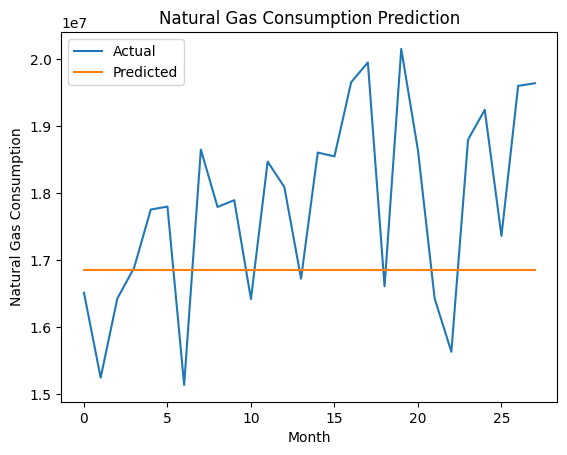

In [18]:
# Visualize the predictions
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Month')
plt.ylabel('Natural Gas Consumption')
plt.title('Natural Gas Consumption Prediction')
plt.legend()
plt.show()

## Make comments
(TODO: comment here)